In [1]:
import gensim
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial import cKDTree
from gensim.models import Doc2Vec
import numpy as np
import csv
import itertools
import nltk
import sklearn.metrics
from sklearn.preprocessing import StandardScaler
import time
import sys
from collections import Counter
import matplotlib.pyplot as plt
import utils, vocabulary
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
model1 = gensim.models.Word2Vec.load('../../all-the-news-dump/d2v-full_utils.model')

In [3]:
#build vocab so we can process IBC sentences in the same way
from nltk.corpus.reader.plaintext import PlaintextCorpusReader

corpusdir = '../../all-the-news-dump/inputs/contents/' # Directory of corpus.

#this is quick
newcorpus = PlaintextCorpusReader(corpusdir, '.*')
#about 10 min for 40k and 100k
#trying 100k - whole vocab is over 300k??
start = time.time()
vocab = utils.build_vocab(newcorpus, V = 100000)
print((time.time()-start)/60)

Vocabulary: 100,000 types
11.26137957572937


In [4]:
def get_numbers_from_tag(tag):
    content = int(tag.split('_')[1])
    token = int(tag.split('_')[3])
    return content, token

In [5]:
def get_sentence(tag):
    if type(tag) == str:
        content, token = get_numbers_from_tag(tag)
        folder = '../../all-the-news-dump/inputs/contents/'
        tname = folder + str(content) + '.txt'
        with open(tname,'r', newline='\n') as tokenfile:
            reader = csv.reader(tokenfile, delimiter='\n')
            for content in reader:
                for paragraph in content:
                    for t, sentence in enumerate(nltk.sent_tokenize(paragraph)):
                        if t == token:
                            return sentence
    else:
        return '(custom sentence)'
                
            
    

In [7]:
get_sentence('CONTENT_83015_TOKEN_1')

'The former Giants quarterback,   as CBS’ lead NFL game analyst, will be moving to “The NFL Today” studio show, the network announced, joining Bill Cowher, Boomer Esiason and Bart Scott.'

In [8]:
get_sentence('CONTENT_112928_TOKEN_0')

'For such a commonplace bodily function, the sneeze has messed with our minds (and noses) for centuries.'

In [6]:
def get_most_similar(model, tag):
    print('Sentences similar to:')
    print(get_sentence(tag))
    print('\n')
    
    sentences = model.docvecs.most_similar(tag)
    for sentence in sentences:
        print(get_sentence(sentence[0]), round(sentence[1], 3), sentence[0])

In [12]:
get_most_similar(model1, 'CONTENT_95141_TOKEN_76')

Sentences similar to:
And it’s so far down a hole, we need for it to be taken out.


It looks like a hole in the sky. 0.787 CONTENT_135246_TOKEN_1
I have a hole in my mouth. 0.782 CONTENT_53764_TOKEN_318
Where is the hole? 0.78 CONTENT_115066_TOKEN_10
2 billion hole” for the company. 0.778 CONTENT_123642_TOKEN_23
A**hole. 0.774 CONTENT_37159_TOKEN_92
Sean Illing That’s a rabbit hole I’m tempted to tumble down, but I’ll resist the temptation for now. 0.772 CONTENT_130626_TOKEN_73
He won’t lie down and he won’t hide behind anything. 0.772 CONTENT_112342_TOKEN_94
“They don’t want you to climb out of the hole. 0.768 CONTENT_7702_TOKEN_47
Then we can work our way out of the hole that we’re in,” she said. 0.768 CONTENT_107544_TOKEN_15
There will just be a hole to pee out of. 0.767 CONTENT_84958_TOKEN_20


In [15]:
new_tokens = "Hello my name is Bob and I am the president.".split()

new_vector = model1.infer_vector(new_tokens)
get_most_similar(model1, [new_vector])

Sentences similar to:
(custom sentence)


i. am was on it. 0.83 CONTENT_140026_TOKEN_33
Breitbart News Daily airs weekdays from 6 am to 9 am EST on SiriusXM Patriot 125. 0.801 CONTENT_23208_TOKEN_26
Please select the extension that is blocking ads. 0.798 CONTENT_55681_TOKEN_1
”This is why I am.” 0.796 CONTENT_114805_TOKEN_101
I’m sure things are changing. 0.792 CONTENT_99194_TOKEN_41
A. 0.792 CONTENT_86231_TOKEN_50
” Breitbart News Daily airs weekdays from 6 am to 9 am EST on SiriusXM Patriot 125. 0.792 CONTENT_29350_TOKEN_13
A. 0.792 CONTENT_1641_TOKEN_47
The answer is yes, he did. 0.791 CONTENT_101847_TOKEN_68
The  . 0.785 CONTENT_136409_TOKEN_98


In [63]:
scaler = StandardScaler()
doc_vectors = model1.docvecs.doctag_syn0
doc_vectors_scaled = scaler.fit_transform(model1.docvecs.doctag_syn0)

/home/samird121/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  
/home/samird121/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
pca = PCA(n_components=50)
doc_pca = pca.fit_transform(doc_vectors)

In [16]:
sum(pca.explained_variance_ratio_)

0.77215821861516853

In [14]:
pca_scaled = PCA(n_components=50)
doc_pca_scaled = pca_scaled.fit_transform(doc_vectors_scaled)

In [15]:
pca_scaled.explained_variance_ratio_

array([ 0.1666947 ,  0.03990277,  0.03671655,  0.02522086,  0.02160291,
        0.0198085 ,  0.01804867,  0.01800926,  0.01721138,  0.01573079,
        0.01540003,  0.01503696,  0.01453951,  0.01375047,  0.01348968,
        0.01314856,  0.01251328,  0.01209503,  0.01199741,  0.01143067,
        0.01130552,  0.01109713,  0.01077501,  0.01066918,  0.01042532,
        0.01024231,  0.01007736,  0.00983247,  0.00956106,  0.00939006,
        0.00920981,  0.00900597,  0.00898013,  0.00862061,  0.00843198,
        0.00836685,  0.00824049,  0.00800313,  0.00798   ,  0.00776551,
        0.00763152,  0.00754431,  0.00743053,  0.00721192,  0.00710269,
        0.00694994,  0.00684698,  0.00679975,  0.00659621,  0.00658724])

In [17]:
sum(pca_scaled.explained_variance_ratio_)

0.77102898413407572

In [20]:
km_pca = KMeans(n_clusters = 3)
clusters_pca = km_pca.fit_predict(doc_pca)

In [21]:
km_pca_scaled = KMeans(n_clusters = 3)
clusters_pca_scaled = km_pca_scaled.fit_predict(doc_pca_scaled)

In [64]:
start = time.time()
km_original_vectors = KMeans(n_clusters = 3)
clusters_ov = km_original_vectors.fit_predict(doc_vectors)
print((time.time()-start)/60)

1.0276446421941121


In [326]:
tags = list(model1.docvecs.doctags)

c1 = [tags[i] for i in range(len(tags)) if clusters[i] == 0]
c2 = [tags[i] for i in range(len(tags)) if clusters[i] == 1]
c3 = [tags[i] for i in range(len(tags)) if clusters[i] == 2]
#c4 = [vocab[i] for i in range(len(vocab)) if clusters[i] == 3]
#c5 = [vocab[i] for i in range(len(vocab)) if clusters[i] == 4]
#c6 = [vocab[i] for i in range(len(vocab)) if clusters[i] == 5]
#c7 = [vocab[i] for i in range(len(vocab)) if clusters[i] == 6]
#c8 = [vocab[i] for i in range(len(vocab)) if clusters[i] == 7]
#c9 = [vocab[i] for i in range(len(vocab)) if clusters[i] == 8]
#c10 = [vocab[i] for i in range(len(vocab)) if clusters[i] == 9]
print([len(c) for c in [c1, c2, c3]])

[245908, 761479, 775476]


In [18]:
def find_k_closest(centroids, data, k=1, distance_norm=2):
    """
    Arguments:
    ----------
        centroids: (M, d) ndarray
            M - number of clusters
            d - number of data dimensions
        data: (N, d) ndarray
            N - number of data points
        k: int (default 1)
            nearest neighbour to get
        distance_norm: int (default 2)
            1: Hamming distance (x+y)
            2: Euclidean distance (sqrt(x^2 + y^2))
            np.inf: maximum distance in any dimension (max((x,y)))

    Returns:
    -------
        indices: (M,) ndarray
        values: (M, d) ndarray
    """

    kdtree = cKDTree(data)
    distances, indices = kdtree.query(centroids, k, p=distance_norm)
    #if k > 1:
    #    indices = indices[:,-1]
    values = data[indices]
    return indices, values



In [38]:
centroids = km_pca.cluster_centers_ 
indices_pca, values_pca = find_k_closest(centroids, doc_pca, k=30)

In [39]:
centroids = km_pca_scaled.cluster_centers_ 
indices_pca_scaled, values = find_k_closest(centroids, doc_pca_scaled, k=30)

In [65]:
centroids = km_original_vectors.cluster_centers_ 
indices_ov, values = find_k_closest(centroids, doc_vectors, k=50)

Top 50 sentences closest to the centroids for each cluster.

In [22]:
model1.docvecs.doctags

{'CONTENT_112928_TOKEN_0': Doctag(offset=0, word_count=19, doc_count=1),
 'CONTENT_112928_TOKEN_1': Doctag(offset=1, word_count=11, doc_count=1),
 'CONTENT_112928_TOKEN_2': Doctag(offset=2, word_count=12, doc_count=1),
 'CONTENT_112928_TOKEN_3': Doctag(offset=3, word_count=18, doc_count=1),
 'CONTENT_112928_TOKEN_4': Doctag(offset=4, word_count=9, doc_count=1),
 'CONTENT_112928_TOKEN_5': Doctag(offset=5, word_count=5, doc_count=1),
 'CONTENT_112928_TOKEN_6': Doctag(offset=6, word_count=8, doc_count=1),
 'CONTENT_112928_TOKEN_7': Doctag(offset=7, word_count=17, doc_count=1),
 'CONTENT_112928_TOKEN_8': Doctag(offset=8, word_count=17, doc_count=1),
 'CONTENT_112928_TOKEN_9': Doctag(offset=9, word_count=20, doc_count=1),
 'CONTENT_112928_TOKEN_10': Doctag(offset=10, word_count=16, doc_count=1),
 'CONTENT_112928_TOKEN_11': Doctag(offset=11, word_count=8, doc_count=1),
 'CONTENT_112928_TOKEN_12': Doctag(offset=12, word_count=18, doc_count=1),
 'CONTENT_112928_TOKEN_13': Doctag(offset=13, wor

In [68]:
for index in indices_ov[2]:
    print(get_sentence(list(model1.docvecs.doctags)[index]))

Drucker is seen holding a peeled grapefruit in her lap.
”) The Everett city council is expected to hold three public hearings before the final vote.
And later, when Michael was, in his own words, entrapped by police, arrested, and forcibly outed as gay, I saw him as confirmation of my fear.
The Islamic State group claimed responsibility for both attacks, but authorities have said the Afghan teen likely acted alone.
But if they are enriching the family of the secretary of state  —   and, alas, likely future president of these United States  —   then that is another story entirely.
A lot of Brazilians outside of major cities are fairly conservative morally, and the evangelical agenda resonates with them, ?
While meeting with members of the Diet to push for a gender identity law, she was reportedly told by a lawmaker that she could only make her case if she went public with the cause.
”                                               ” ”                                                 “I kn

In [67]:
#get journal names

#initialize array with empty string
#the counts that give names to the contents/tokens start at 1, not 0
pubs = ['']

csv.field_size_limit(sys.maxsize)

start = time.time()
fnames = ['../../.kaggle/datasets/snapcrack/all-the-news/articles1.csv', '../../.kaggle/datasets/snapcrack/all-the-news/articles2.csv', '../../.kaggle/datasets/snapcrack/all-the-news/articles3.csv']
for fname in fnames:
    f = open(fname)
    reader = csv.reader(f)
    next(reader, None)  # skip the headers
    for line in reader:
        pubs.append(line[3])
        
print(time.time()-start)

16.450567960739136


In [68]:
pub_clusters = [[], [], []]
start = time.time()
tags = list(model1.docvecs.doctags)

for n in range(3):
    pub_clusters[n] = [pubs[get_numbers_from_tag(tags[i])[0]] for i in range(len(labels)) if labels[i]==n]

    
print(time.time()-start)

8.22530460357666


In [106]:
labels

[0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 2,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 2,
 0,
 1,
 2,
 1,
 0,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 0,
 2,
 0,
 0,
 1,
 2,
 1,
 1,
 0,
 1,
 1,
 1,
 2,
 2,
 2,
 1,
 2,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 2,
 0,
 2,
 2,
 2,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 2,
 2,
 0,
 2,
 2,
 1,
 2,
 0,
 2,
 2,
 0,
 0,
 2,
 2,
 1,
 2,
 0,
 0,
 0,
 2,
 1,
 2,
 0,
 0,
 1,
 0,
 2,
 0,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 0,
 0,
 1,
 1,
 1,
 2,
 0,
 0,
 1,
 2,
 0,
 1,
 2,
 1,
 0,
 1,
 1,
 1,
 2,
 1,
 1,
 0,
 1,
 2,
 0,
 0,
 0,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 2,
 0,
 1,
 0,
 1,
 1,
 2,
 0,
 0,
 1,
 1,
 2,
 1,
 0,
 1,
 0,
 2,
 1,
 2,
 2,
 1,
 2,
 1,
 0,
 0,
 1,
 2,
 1,
 0,
 1,
 2,
 1,
 2,
 0,
 2,
 1,
 1,
 1,
 2,
 2,
 0,
 2,
 1,
 1,
 0,
 2,
 1,
 1,
 2,
 0,
 0,
 2,
 0,
 1,
 1,
 0,
 2,
 1,
 0,
 2,
 1,
 0,
 1,
 1,
 1,
 0,
 2,
 0,
 0,
 2,
 2,


In [148]:
all_sentences_list = np.concatenate((lib_sentences, con_sentences, neu_sentences))

In [153]:
count = 0
i = 0
while count <= 10:
    sim = max_sims[i]
    if sim < .9:
        i += 1
    else:
        tag = doctags[i]
        index = max_indeces[i]
        ibc_sentence = all_sentences_list[index]
        atn_sentence = get_sentence(tag)
        sim = max_sims[i]
        print('\nIBC:')
        print(ibc_sentence)
        print('ATN:')
        print(atn_sentence)
        print('\nSimilarity:', sim)
        
        count += 1
        i += 1


IBC:
Senator James Inhofe ( R-Okla . )
ATN:
A.

Similarity: 0.930929

IBC:
Senator James Inhofe ( R-Okla . )
ATN:
A:  .

Similarity: 0.911622

IBC:
Gr \/ .
ATN:
S .

Similarity: 0.913473

IBC:
But Tea Party favorite Senator Rand Paul ( R-Ky . )
ATN:
The  .

Similarity: 0.929417

IBC:
Senator James Inhofe ( R-Okla . )
ATN:
by Elaine Godfrey (@elainejgodfrey)

Similarity: 0.9194

IBC:
Gr \/ .
ATN:
83 percent.

Similarity: 0.918896

IBC:
Senator James Inhofe ( R-Okla . )
ATN:
A.

Similarity: 0.921075

IBC:
Senator James Inhofe ( R-Okla . )
ATN:
Of.

Similarity: 0.92529

IBC:
Senator James Inhofe ( R-Okla . )
ATN:
And?

Similarity: 0.929872

IBC:
Senator James Inhofe ( R-Okla . )
ATN:
8% and the   Nasdaq dropped 2.

Similarity: 0.924706

IBC:
Senator James Inhofe ( R-Okla . )
ATN:
A.

Similarity: 0.922816


In [140]:
total_pubs = [{},{},{}]
sims = [{},{},{}]
for i in range(len(weak_labels)):
    label = weak_labels[i]
    sim = max_sims[i]
    content_number = get_numbers_from_tag(tags[i])[0]
    pub = pubs[content_number]
    
    if pub in total_pubs[label].keys():
        total_pubs[label][pub] += 1
        sims[label][pub] = np.max([sims[label][pub], sim])
    else:
        total_pubs[label].update({pub:1})
        sims[label].update({pub:sim})

In [121]:
for i in range(3):
    sim = sims[i]
    total = total_pubs[i]
    for key in sim.keys():
        sim[key] /= total[key]

In [141]:
sims

[{'Atlantic': 0.82097435,
  'Breitbart': 0.84072971,
  'Business Insider': 0.82517409,
  'Buzzfeed News': 0.80394554,
  'CNN': 0.80660677,
  'Fox News': 0.77415609,
  'Guardian': 0.8257761,
  'NPR': 0.82391322,
  'National Review': 0.81654173,
  'New York Post': 0.84726,
  'New York Times': 0.87548846,
  'Reuters': 0.83362955,
  'Talking Points Memo': 0.7855171,
  'Vox': 0.79273856,
  'Washington Post': 0.80891609},
 {'Atlantic': 0.92804027,
  'Breitbart': 0.92987216,
  'Business Insider': 0.920789,
  'Buzzfeed News': 0.89103979,
  'CNN': 0.9228164,
  'Fox News': 0.83909941,
  'Guardian': 0.92470592,
  'NPR': 0.8713572,
  'National Review': 0.85796344,
  'New York Post': 0.94400275,
  'New York Times': 0.93092853,
  'Reuters': 0.87576818,
  'Talking Points Memo': 0.85015923,
  'Vox': 0.85023046,
  'Washington Post': 0.94748127},
 {'Atlantic': 0.88090289,
  'Breitbart': 0.92331982,
  'Business Insider': 0.83959627,
  'Buzzfeed News': 0.83840835,
  'CNN': 0.89581883,
  'Fox News': 0.8501

In [69]:
c0 = Counter(pub_clusters[0])
c1 = Counter(pub_clusters[1])
c2 = Counter(pub_clusters[2])

c_all = Counter(pubs)

In [70]:
c_all

Counter({'': 1,
         'Atlantic': 7179,
         'Breitbart': 23781,
         'Business Insider': 6757,
         'Buzzfeed News': 4854,
         'CNN': 11488,
         'Fox News': 4354,
         'Guardian': 8681,
         'NPR': 11992,
         'National Review': 6203,
         'New York Post': 17493,
         'New York Times': 7803,
         'Reuters': 10710,
         'Talking Points Memo': 5214,
         'Vox': 4947,
         'Washington Post': 11114})

In [71]:
#normalize counts by total counts to get percentages
for pub in ['Atlantic', 'Breitbart', 'Business Insider', 'Buzzfeed News', 'CNN', 'Fox News', 'Guardian', 'NPR', 'National Review', 'New York Post', 'New York Times', 'Reuters', 'Talking Points Memo', 'Vox', 'Washington Post']:
    total = c0[pub] + c1[pub] + c2[pub]
    c0[pub] /= total
    c1[pub] /= total
    c2[pub] /= total

In [142]:
c0 = sims[0]
c1 = sims[1]
c2 = sims[2]

What % of each publication is represented in each cluster?

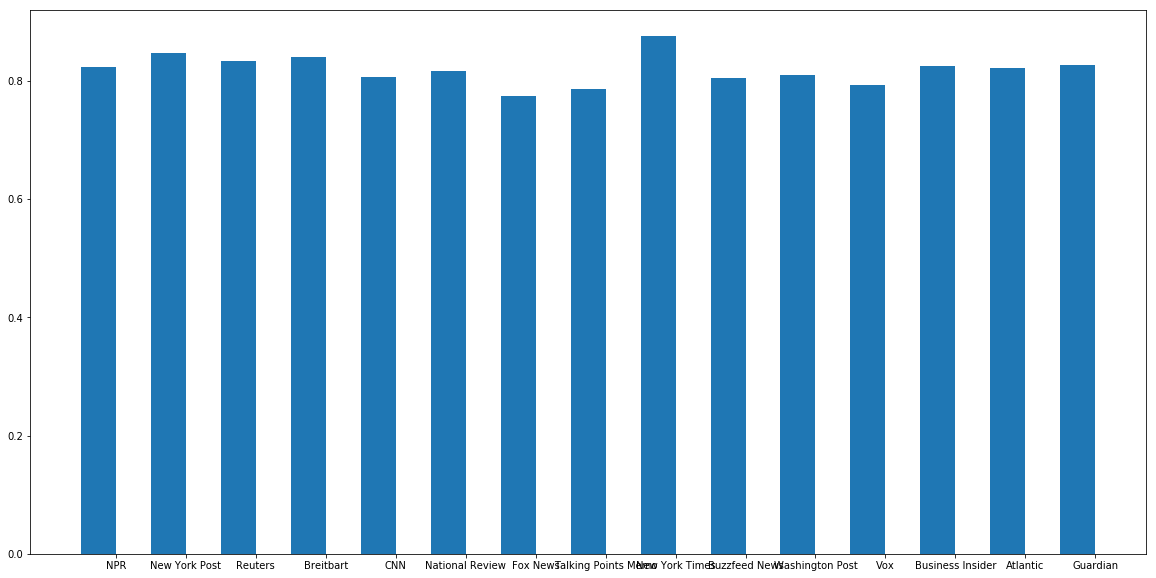

In [143]:
labels, values = zip(*c0.items())

indexes = np.arange(len(labels))
width = .5

plt.figure(figsize=(20,10))
plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

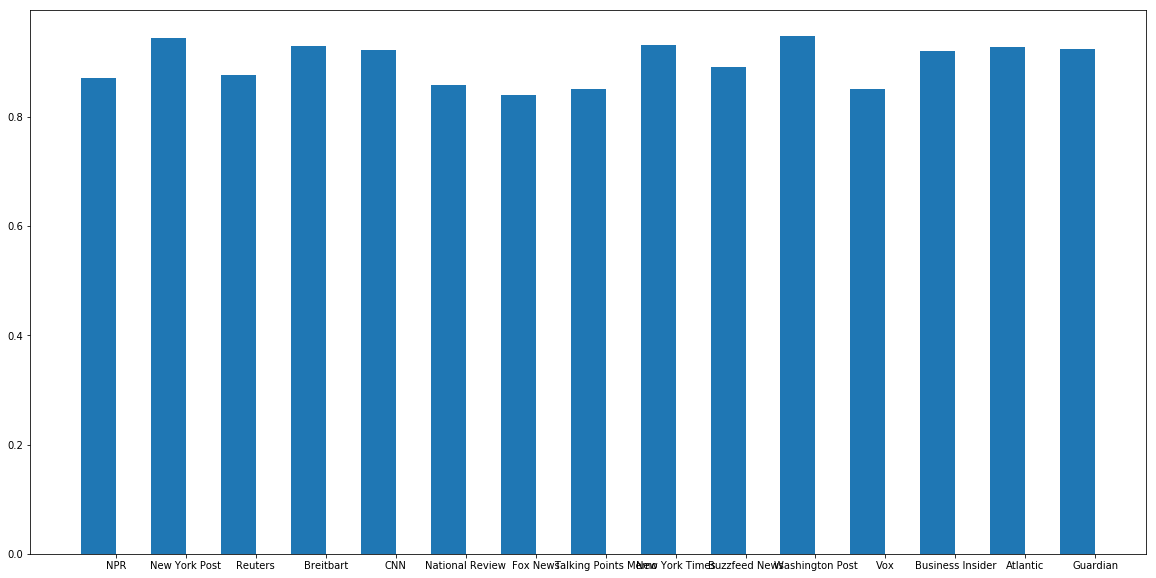

In [144]:
labels, values = zip(*c1.items())

indexes = np.arange(len(labels))
width = .5

plt.figure(figsize=(20,10))
plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

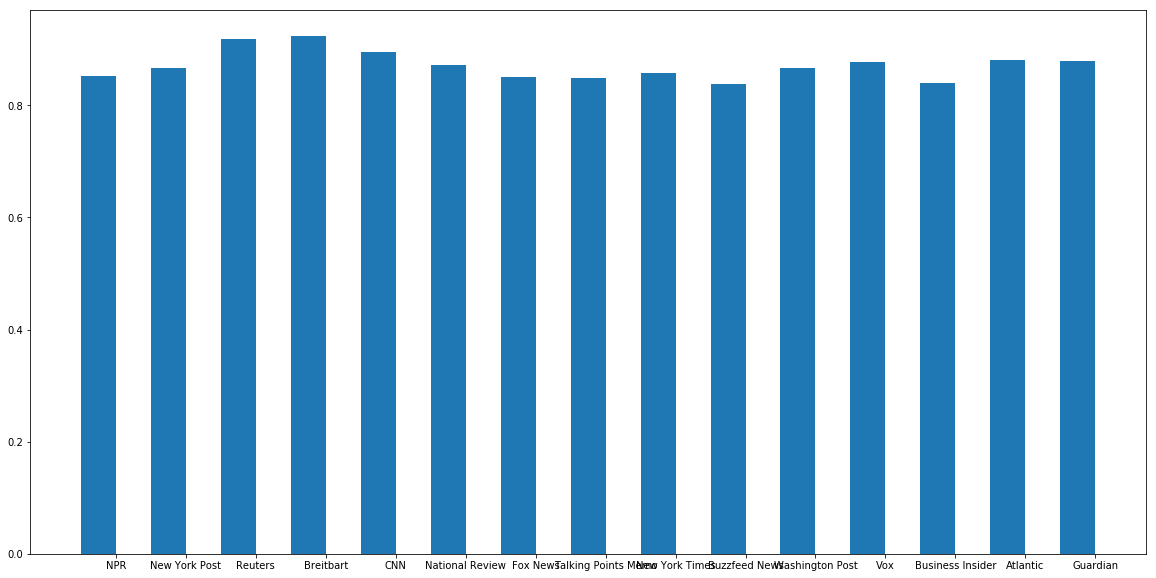

In [145]:
labels, values = zip(*c2.items())

indexes = np.arange(len(labels))
width = .5

plt.figure(figsize=(20,10))
plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

Weak annotations based on IBC

In [7]:
import re
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import *

In [8]:
#from author who provided us with dataset: import data, show some examples
import _pickle as cPickle

if __name__ == '__main__':
    [lib, con, neutral] = cPickle.load(open('ibcData.pkl', 'rb'))

    # how to access sentence text
    print('Liberal examples (out of ', len(lib), ' sentences): ')
    for tree in lib[0:5]:
        print(tree.get_words())

    print('\nConservative examples (out of ', len(con), ' sentences): ')
    for tree in con[0:5]:
        print(tree.get_words())

    print('\nNeutral examples (out of ', len(neutral), ' sentences): ')
    for tree in neutral[0:5]:
        print(tree.get_words())

    # how to access phrase labels for a particular tree
    ex_tree = lib[0]

    print('\nPhrase labels for one tree: ')

    # see treeUtil.py for the tree class definition
    for node in ex_tree:

        # remember, only certain nodes have labels (see paper for details)
        if hasattr(node, 'label'):
            print(node.label, ': ', node.get_words())

Liberal examples (out of  2025  sentences): 
Forcing middle-class workers to bear a greater share of the cost of government weakens their support for needed investments and stirs resentment toward those who depend on public services the most .
Because it would not be worthwhile to bring a case for $ 30.22 , the arbitration clause would , as a practical matter , deny the Concepcions any relief and , more important , eliminate a class action that might punish AT&T for its pattern of fraudulent behavior .
Indeed , Lind argues that high profits and high wages reinforce each other because workers then have the wherewithal to buy the products they are making .
In fairness , it should be noted that he devotes an entire chapter to New York Times political columnist Maureen Dowd , a liberal who makes much of the outsized rivalries , jealousies , and personalities that dominate American politics .
Psychological tactics are social control techniques that operate at the level of the mind , with th

In [9]:
#two arrays - sentences and lib/con/neu labels


lib_sentences = []
con_sentences = []
neu_sentences = []
labels = []

for i in range(len(lib)):
    lib_sentences.append(lib[i].get_words())
    labels.append('liberal')
    
for i in range(len(con)):
    con_sentences.append(con[i].get_words())
    labels.append('conservative')
    
for i in range(len(neutral)):
    neu_sentences.append(neutral[i].get_words())
    labels.append('neutral')

In [14]:
tokenizer = nltk.tokenize.regexp.RegexpTokenizer(r'\w+')
sentence = tokenizer.tokenize(con_sentences[0])
psentence = ' '.join(vocab.ids_to_words(utils.preprocess_sentences([sentence], vocab)))
get_most_similar(model1, [model1.infer_vector(psentence.split())])

Sentences similar to:
(custom sentence)


” This wasn’t an argument or a policy; it was a sentiment. 0.603 CONTENT_93806_TOKEN_29
Could he totally collapse from that position? 0.595 CONTENT_18114_TOKEN_2
I reject that framework and the outcomes that flow from it, preferring a liberal approach that emphasizes   protections and   rules. 0.584 CONTENT_52814_TOKEN_17
The left, as championed by Bernie Sanders, has adopted a categorical ”no fracking” stance. 0.581 CONTENT_129429_TOKEN_74
Presidencies can be defined as much by their approach to politics as by their approach to policy. 0.578 CONTENT_128360_TOKEN_45
They are both, broadly speaking, networks with the market power created by path dependence. 0.575 CONTENT_63261_TOKEN_36
Landis: Totally. 0.571 CONTENT_63076_TOKEN_190
Whatever the merits of this haze of uncertainty as a pure political marketing strategy, it completely poisons the environment for negotiations. 0.563 CONTENT_127565_TOKEN_16
“There was no pressure from the White House

In [10]:
doctags = list(model1.docvecs.doctags)

In [11]:
def get_inferred_vector(sentence, model, vocab):
    sentence = tokenizer.tokenize(sentence)
    psentence = ' '.join(vocab.ids_to_words(utils.preprocess_sentences([sentence], vocab)))
    return model.infer_vector(psentence.split())
    

In [48]:
get_inferred_vector('hello my nam eis lewijaflwefjawe?F?? , hiiii', model1, vocab)

array([ 0.06417029, -0.08473171,  0.02100163,  0.0226915 ,  0.10502367,
       -0.14665528,  0.05048458,  0.08954067, -0.04336716, -0.00193067,
        0.13460265,  0.00226458, -0.09654584, -0.02545851,  0.14083444,
        0.00154029, -0.13165134,  0.07793714,  0.08379643,  0.00451869,
        0.10882074, -0.08888197,  0.13361943,  0.02859664,  0.06447759,
        0.05645979,  0.02659738,  0.06901204, -0.03137322,  0.09590589,
        0.01048395, -0.0229268 ,  0.15743025,  0.06983408,  0.07459594,
        0.08628467, -0.01765629,  0.04143411, -0.08277632, -0.13746181,
        0.12930253,  0.10558859,  0.10173332, -0.05821139, -0.07386412,
       -0.00744184, -0.04041977, -0.12707847, -0.02014566, -0.12770732,
        0.25048995,  0.02040325,  0.08673828, -0.02158144, -0.13812265,
       -0.11483262, -0.03763771, -0.04695113,  0.02784852, -0.00773293,
       -0.09309666,  0.08390994,  0.01292209,  0.0605974 , -0.07045154,
        0.17401205,  0.08563913,  0.09236813, -0.03257411, -0.11

In [67]:
cosine_similarity(model1.docvecs['CONTENT_112928_TOKEN_7'].reshape(1,-1), model1.docvecs['CONTENT_112928_TOKEN_8'].reshape(1,-1))

array([[ 0.62415934]], dtype=float32)

In [12]:
docvecs = model1.docvecs
len(docvecs)

5000970

In [15]:
lib_vectors = utils.flatten([get_inferred_vector(sentence, model1, vocab).reshape(1,-1) for sentence in lib_sentences])
con_vectors = utils.flatten([get_inferred_vector(sentence, model1, vocab).reshape(1,-1) for sentence in con_sentences])
neu_vectors = utils.flatten([get_inferred_vector(sentence, model1, vocab).reshape(1,-1) for sentence in neu_sentences])

In [16]:
all_vectors = np.concatenate((lib_vectors, con_vectors, neu_vectors))

In [167]:
len(all_vectors)

4326

In [18]:
mean_sims = [[], [], []]
max_sims = []
max_indeces = []

count = 0
start = time.time()
checkpoint = start
for docvec in docvecs_rs:
    
    cs = cosine_similarity(docvec, all_vectors)
    max_sims.append(np.max(cs))
    max_indeces.append(np.argmax(cs))

    
    count += 1
    if count % 25000 == 0:
        print(100*count/5000970, '%, ', 25000/(time.time()-checkpoint), ' per sec')
        checkpoint = time.time()

0.49990301881435 %,  690.9639561861628  per sec
0.9998060376287 %,  713.932027676141  per sec
1.49970905644305 %,  779.446151511387  per sec
1.9996120752574 %,  771.0182616685873  per sec
2.49951509407175 %,  766.1464586553585  per sec
2.9994181128861 %,  797.4215757360795  per sec
3.4993211317004502 %,  746.1754200931764  per sec
3.9992241505148 %,  720.6526031865368  per sec
4.49912716932915 %,  736.0798815596074  per sec
4.9990301881435 %,  723.220872143776  per sec
5.49893320695785 %,  726.6676110928412  per sec
5.9988362257722 %,  686.7059281616073  per sec
6.498739244586551 %,  697.086305341666  per sec
6.9986422634009005 %,  672.9343794897948  per sec
7.49854528221525 %,  621.59478481065  per sec
7.9984483010296 %,  676.7414384972552  per sec
8.49835131984395 %,  651.0476677701347  per sec
8.9982543386583 %,  702.3819471784764  per sec
9.49815735747265 %,  638.1102060900938  per sec
9.998060376287 %,  622.4269504620207  per sec
10.497963395101351 %,  657.9385310089932  per sec
1

84.9835131984395 %,  444.0820312568655  per sec
85.48341621725385 %,  621.6358289071545  per sec
85.9833192360682 %,  560.3411778885892  per sec
86.48322225488255 %,  521.210844145682  per sec
86.9831252736969 %,  468.1979740119708  per sec
87.48302829251125 %,  685.0994073832892  per sec
87.9829313113256 %,  693.9159477155256  per sec
88.48283433013995 %,  693.8942597808855  per sec
88.9827373489543 %,  631.7945414003875  per sec
89.48264036776865 %,  598.3840407791565  per sec
89.982543386583 %,  616.0318780705069  per sec
90.48244640539735 %,  675.4776930271288  per sec
90.9823494242117 %,  648.1149177687386  per sec
91.48225244302606 %,  560.8271417325366  per sec
91.9821554618404 %,  336.679064195337  per sec
92.48205848065476 %,  314.1019611602208  per sec
92.98196149946911 %,  318.7843709427007  per sec
93.48186451828346 %,  327.1459801922396  per sec
93.98176753709781 %,  337.18016711412287  per sec
94.48167055591216 %,  310.9991624274018  per sec
94.9815735747265 %,  381.02697

In [134]:
weak_labels = []
for i in range(len(max_sims)):
    if max_indeces[i] < len(lib_vectors):
        weak_labels.append(0)
    elif max_indeces[i] < (len(lib_vectors)+len(con_vectors)):
        weak_labels.append(1)
    else:
        weak_labels.append(2)

In [63]:
lib_indeces = np.where(np.array(labels)==0)
con_indeces = np.where(np.array(labels)==1)
neu_indeces = np.where(np.array(labels)==2)
lib_tags = doctags[lib_indeces[0].tolist()]
con_tags = doctags[con_indeces[0]]
neu_tags = doctags[neu_indeces[0]]

TypeError: list indices must be integers or slices, not list

In [65]:

for i in range(len(labels)):
    

TypeError: list indices must be integers or slices, not tuple

In [62]:
lib_indeces[0].tolist()

[0,
 1,
 3,
 9,
 14,
 17,
 20,
 24,
 39,
 41,
 42,
 47,
 56,
 57,
 58,
 59,
 61,
 66,
 71,
 86,
 90,
 92,
 95,
 100,
 103,
 104,
 109,
 110,
 111,
 115,
 116,
 118,
 120,
 128,
 129,
 134,
 135,
 138,
 142,
 149,
 152,
 153,
 154,
 168,
 169,
 171,
 172,
 173,
 180,
 182,
 186,
 187,
 192,
 194,
 202,
 203,
 207,
 212,
 219,
 223,
 228,
 229,
 231,
 234,
 237,
 240,
 244,
 246,
 247,
 250,
 251,
 256,
 257,
 275,
 282,
 285,
 286,
 290,
 292,
 293,
 294,
 295,
 297,
 300,
 301,
 302,
 313,
 314,
 317,
 318,
 319,
 320,
 326,
 330,
 334,
 335,
 336,
 337,
 338,
 342,
 348,
 351,
 352,
 353,
 356,
 357,
 359,
 360,
 363,
 364,
 369,
 373,
 375,
 377,
 379,
 390,
 391,
 393,
 395,
 400,
 401,
 402,
 403,
 407,
 409,
 411,
 422,
 423,
 424,
 426,
 429,
 430,
 431,
 433,
 434,
 436,
 439,
 441,
 444,
 445,
 447,
 448,
 456,
 457,
 461,
 465,
 466,
 475,
 479,
 480,
 482,
 487,
 490,
 497,
 503,
 505,
 506,
 507,
 509,
 512,
 514,
 515,
 518,
 522,
 523,
 526,
 528,
 529,
 531,
 532,
 533,
 

In [60]:
isinstance(lib_indeces[0][1], int)

False

In [26]:
with open('d2v-full_utils_labels.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for i in range(len(max_sims)):
        if i % 100000 == 0:
            print(i)
        max_sim = max_sims[i]
        max_index = max_indeces[i]

        writer.writerow([max_sim, max_index])

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
4700000
4800000
4900000
5000000
